In [1]:
import numpy as np
import pandas as pd

from scipy.stats import beta
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm


path = './data/'
output = './output/'
figs = './figs/'

player_ext = 'Players_2019.csv'
event_ext = 'Events_2019.csv'
teams_ext = 'Teams.csv'

df = pd.read_csv(path+event_ext)
players = pd.read_csv(path+player_ext)



In [2]:
def get_time_remain(events):
    events['GameID'] = events['Season'].astype(str) + events['DayNum'].astype(str) + events['WTeamID'].astype(str) + events['LTeamID'].astype(str)
    events['OT'] = (events['ElapsedSeconds'] - 2400)/300
    events['OT'] = np.where(events['OT'] < 0, 0, np.ceil(events['OT'])).astype(int)
    events['TimeRemain'] = 2400 + (events['OT'] * 300) - events['ElapsedSeconds']

    return events


df = get_time_remain(df)


In [3]:

def add_score_diff(events):
    
    events['WDiff'] = events['WPoints'] - events['LPoints']
    
    # relative to event
    events.loc[:,'EDiff'] = np.where(events['EventTeamID']==events['WTeamID'], events['WDiff'], -1*events['WDiff'])
    
    
    return events

df = add_score_diff(df)


In [4]:
print(df.EventType.unique())


['assist' 'made2_jump' 'turnover' 'made3_jump' 'foul_pers' 'miss2_jump'
 'reb_def' 'miss3_jump' 'reb_off' 'miss1_free' 'sub_in' 'made1_free'
 'sub_out' 'steal' 'block' 'made2_dunk' 'timeout_tv' 'made2_lay'
 'miss2_lay' 'reb_dead' 'timeout' 'miss2_dunk' 'made2_tip' 'miss2_tip'
 'foul_tech']


In [5]:
df.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,GameID,OT,TimeRemain,WDiff,EDiff
0,30099809,2019,1,1104,1380,0,0,18,1380,657441,assist,2019111041380,0,2382,0,0
1,30099810,2019,1,1104,1380,0,2,18,1380,657447,made2_jump,2019111041380,0,2382,-2,2
2,30099811,2019,1,1104,1380,2,2,42,1104,653561,made2_jump,2019111041380,0,2358,0,0
3,30099812,2019,1,1104,1380,0,0,58,1380,657437,turnover,2019111041380,0,2342,0,0
4,30099813,2019,1,1104,1380,0,0,63,1104,653565,assist,2019111041380,0,2337,0,0


In [6]:
# identify pairs and triplets of free throws
# they don't necessarily have consecutive event ids
# this is so that we can figure out if a free throw ends a possession


def get_pairs(events):
    
    events['TotalPoints'] = events['WPoints'] + events['LPoints']
    fts = ['made1_free','miss1_free']
    events['IsFT'] = np.where(events['EventType'].isin(fts), 'free_throw', events['EventType'])
    egb = events.groupby(['GameID','ElapsedSeconds','EventTeamID','IsFT'])['EventID'].count().reset_index()
    egb = egb.loc[(egb['IsFT']=='free_throw')&(egb['EventID']>1)]
    egb['PairOrTrip'] = 1
    egb.loc[egb['EventID']>3, 'PairOrTrip'] = 2
    egb = egb[['GameID','ElapsedSeconds','EventTeamID','PairOrTrip']]
    
    
    # separate ft df to keep event id information
    ft_df = events.loc[events['IsFT']=='free_throw']
    ft_df = ft_df[['EventID','GameID','ElapsedSeconds','EventTeamID','TotalPoints']]
    ft_df = ft_df.sort_values(by=['GameID','ElapsedSeconds','TotalPoints'])
    
    ft_df = pd.merge(ft_df, egb, how='left', left_on=['GameID','ElapsedSeconds','EventTeamID'], right_on=['GameID','ElapsedSeconds','EventTeamID'])

    # last deal is to separate out the 800 or so quadruple and quintuple sets of FTs
    doubles = ft_df.loc[ft_df['PairOrTrip']>1]
    
    egb = ft_df.groupby(['GameID','ElapsedSeconds','EventTeamID'])['EventID'].last().reset_index()
    # this marks the third to last FT in the quadruples and quintuples
    doubles = doubles.groupby(['GameID','ElapsedSeconds','EventTeamID'])['EventID'].nth(-2).reset_index()
    
    egb = egb[['EventID']]
    doubles = doubles[['EventID']]

    egb = pd.concat([egb,doubles], axis=0)
    
    egb['FTPossEnd'] = 1
    
    events = pd.merge(events,egb,how='left',on=['EventID','EventID']) 
    
    events['FTPossEnd'] = events['FTPossEnd'].copy().fillna(0)
    return events
# treat made and missed FTs the same

df = get_pairs(df)

df.loc[df['IsFT']=='free_throw'].head(5)



,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,GameID,OT,TimeRemain,WDiff,EDiff,TotalPoints,IsFT,FTPossEnd
18,30099827,2019,1,1104,1380,0,0,177,1104,653562,miss1_free,2019111041380,0,2223,0,0,0,free_throw,0.0
22,30099831,2019,1,1104,1380,8,4,177,1104,653562,made1_free,2019111041380,0,2223,4,4,12,free_throw,1.0
103,30099912,2019,1,1104,1380,0,0,607,1380,657437,miss1_free,2019111041380,0,1793,0,0,0,free_throw,0.0
104,30099913,2019,1,1104,1380,0,0,607,1380,657437,miss1_free,2019111041380,0,1793,0,0,0,free_throw,0.0
105,30099914,2019,1,1104,1380,0,0,607,1380,657437,miss1_free,2019111041380,0,1793,0,0,0,free_throw,1.0


In [7]:
# now find other possession enders

# field goal attempts end possessions
fgas = ['made2_jump','made3_jump','made2_dunk','made2_tip','made2_lay','miss2_jump','miss3_jump','miss2_dunk','miss2_tip','miss2_lay']

# turnovers end possessions

# field goal makes begin possessions for the other team
fgms = ['made2_jump','made3_jump','made2_dunk','made2_tip','made2_lay']

# free throw makes on last fts begin poss for other team
# ftms = ['made1_free']

# rebounds begin possessions
rebs = ['reb_off','reb_def','reb_team']

# offensive rebounds end your own possession as well?

def add_poss_markers(events): 
    events['OtherTeam'] = np.where(events['EventTeamID']==events['WTeamID'], events['LTeamID'], events['WTeamID'])
    events['PossBegin'] = np.nan
    events['PossEnd'] = np.nan
    
    events['PossEnd'] = np.where(events['EventType'].isin(fgas), events['EventTeamID'], events['PossEnd'])
    events['PossEnd'] = np.where(events['EventType']=='turnover',events['EventTeamID'], events['PossEnd'])
    events['PossEnd'] = np.where(events['FTPossEnd']==1, events['EventTeamID'],events['PossEnd'])
    
    events['PossBegin'] = np.where(events['EventType'].isin(rebs), events['EventTeamID'], events['PossBegin'])
    events['PossBegin'] = np.where(events['EventType']=='turnover',events['OtherTeam'], events['PossBegin'])
    events['PossBegin'] = np.where(events['EventType'].isin(fgms), events['OtherTeam'], events['PossBegin'])
    events['PossBegin'] = np.where(((events['EventType']=='made1_free')&(events['FTPossEnd']==1)), events['OtherTeam'], events['PossBegin'])
    
    events['PossBegin'] = events['PossBegin'].fillna(0)
    events['PossEnd'] = events['PossEnd'].fillna(0)
    
    events['PossBegin'] = events['PossBegin'].astype(int)
    events['PossEnd'] = events['PossEnd'].astype(int)
    return events

    
    
df = add_poss_markers(df)

# df.to_csv(output+'sample',index=None)

df.head()


,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,...,OT,TimeRemain,WDiff,EDiff,TotalPoints,IsFT,FTPossEnd,OtherTeam,PossBegin,PossEnd
0,30099809,2019,1,1104,1380,0,0,18,1380,657441,...,0,2382,0,0,0,assist,0.0,1104,0,0
1,30099810,2019,1,1104,1380,0,2,18,1380,657447,...,0,2382,-2,2,2,made2_jump,0.0,1104,1104,1380
2,30099811,2019,1,1104,1380,2,2,42,1104,653561,...,0,2358,0,0,4,made2_jump,0.0,1380,1380,1104
3,30099812,2019,1,1104,1380,0,0,58,1380,657437,...,0,2342,0,0,0,turnover,0.0,1104,1104,1380
4,30099813,2019,1,1104,1380,0,0,63,1104,653565,...,0,2337,0,0,0,assist,0.0,1380,0,0


In [8]:
df = df.drop(columns=['IsFT','FTPossEnd','TotalPoints'])


In [9]:
print(list(df))

['EventID', 'Season', 'DayNum', 'WTeamID', 'LTeamID', 'WPoints', 'LPoints', 'ElapsedSeconds', 'EventTeamID', 'EventPlayerID', 'EventType', 'GameID', 'OT', 'TimeRemain', 'WDiff', 'EDiff', 'OtherTeam', 'PossBegin', 'PossEnd']


In [10]:
# add tipoff, halftime opening poss, ot opening poss, end of game markers


# def create_tipoffs(events):
#     blank = df.groupby(['Season','GameID','DayNum','WTeamID','LTeamID'])['EventID'].apply(lambda x: x.shift(-1).iloc[-1]).reset_index()
#     tipoff = blank.copy()
#     # start with negative one so i can identify where game starts later
#     tipoff['WPoints'],tipoff['LPoints'] = -1,-1
#     tipoff['ElapsedSeconds'] = 0
#     tipoff['EventID']= 0
#     tipoff['EventPlayerID']= 0
#     tipoff['EventType'] = 'reb_team'
#     tipoff['TimeRemain'] = 2400
#     tipoff['WDiff'],tipoff['EDiff'] = 0,0
#     tipoff['PossEnd'] = 0
#     tipoff['OT'] = 0
    
#     # find first team with possession end
#     pes = df.loc[df['PossEnd']!=0]
#     pes = pes.groupby(['GameID'])['PossEnd'].first().reset_index()
#     pes = pes.rename(columns={'PossEnd':'PossBegin'})


#     tipoff = pd.merge(tipoff, pes, how='left', on=['GameID','GameID'])
#     tipoff['EventTeamID'] = tipoff['PossBegin']
#     tipoff['OtherTeam'] = np.where(tipoff['EventTeamID']==tipoff['WTeamID'], tipoff['LTeamID'], tipoff['WTeamID'])
    
#     tipoff = tipoff[list(events)]
#     events = pd.concat([events,tipoff],axis=0, sort=False)
#     return events


# df = create_tipoffs(df)

# df = df.sort_values(by=['GameID','ElapsedSeconds'])
# df.head()





In [11]:
df['TimeRemainHalf'] = np.where(df['TimeRemain']<1200, df['TimeRemain'], df['TimeRemain']-1200)
print(list(df))


['EventID', 'Season', 'DayNum', 'WTeamID', 'LTeamID', 'WPoints', 'LPoints', 'ElapsedSeconds', 'EventTeamID', 'EventPlayerID', 'EventType', 'GameID', 'OT', 'TimeRemain', 'WDiff', 'EDiff', 'OtherTeam', 'PossBegin', 'PossEnd', 'TimeRemainHalf']


In [12]:
# create opening second half

def create_osh(events):
    blank = df.groupby(['Season','GameID','DayNum','WTeamID','LTeamID'])['EventID'].apply(lambda x: x.shift(-1).iloc[-1]).reset_index()
    osh = blank.copy()
    osh['WPoints'],osh['LPoints'] = 0,0
    osh['ElapsedSeconds'] = 1201
    osh['EventID']= 0
    osh['EventPlayerID']= 0
    osh['EventType'] = 'reb_team'
    osh['TimeRemain'] = 1199
    osh['TimeRemainHalf'] = 1199
    osh['WDiff'],osh['EDiff'] = 0,0
    osh['PossEnd'] = 0
    osh['OT'] = 0
    
    # find first team with possession end
    pes = df.loc[(df['PossEnd']!=0)&(df['TimeRemain']<1200)]
    pes = pes.groupby(['GameID'])['PossEnd'].first().reset_index()
    pes = pes.rename(columns={'PossEnd':'PossBegin'})


    osh = pd.merge(osh, pes, how='left', on=['GameID','GameID'])
    osh['EventTeamID'] = osh['PossBegin']
    osh['OtherTeam'] = np.where(osh['EventTeamID']==osh['WTeamID'], osh['LTeamID'], osh['WTeamID'])
    
    osh = osh[list(events)]
    events = pd.concat([events,osh],axis=0, sort=False)
    
    
    return events


df = create_osh(df)

In [13]:
test = df.loc[df['TimeRemain']==1199]
test.groupby(['EventType'])['ElapsedSeconds'].count()

EventType
miss2_jump       2
reb_def          1
reb_team      5457
steal            2
sub_in          16
sub_out         17
turnover         5
Name: ElapsedSeconds, dtype: int64

In [14]:
df = df.sort_values(by=['GameID','ElapsedSeconds','EventID'])

def create_end_first_half(events):
    
    return events

def create_end_game(events):
    
    return events

def create_ot_begin(events):
    return events

def create_end_ot(events):
    return events

In [15]:
df.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,GameID,OT,TimeRemain,WDiff,EDiff,OtherTeam,PossBegin,PossEnd,TimeRemainHalf
1896418,31996227,2019,100,1101,1311,0,0,29,1101,653515,assist,201910011011311,0,2371,0,0,1311,0,0,1171
1896419,31996228,2019,100,1101,1311,3,0,29,1101,653508,made3_jump,201910011011311,0,2371,3,3,1311,1311,1101,1171
1896420,31996229,2019,100,1101,1311,0,0,58,1311,656456,turnover,201910011011311,0,2342,0,0,1101,1101,1311,1142
1896421,31996230,2019,100,1101,1311,0,0,60,1101,653519,steal,201910011011311,0,2340,0,0,1311,0,0,1140
1896422,31996231,2019,100,1101,1311,0,0,63,1311,656456,foul_pers,201910011011311,0,2337,0,0,1101,0,0,1137


In [16]:
df = df.sort_values(by=['Season','DayNum','GameID','ElapsedSeconds'])
df['NWPoints']= df['WPoints'].replace(to_replace=0, method='ffill')
df['NLPoints']= df['LPoints'].replace(to_replace=0, method='ffill')

df['NWPoints'] = df['NWPoints'].replace(-1,0)
df['NLPoints'] = df['NLPoints'].replace(-1,0)

df.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,...,OT,TimeRemain,WDiff,EDiff,OtherTeam,PossBegin,PossEnd,TimeRemainHalf,NWPoints,NLPoints
0,30099809,2019,1,1104,1380,0,0,18,1380,657441,...,0,2382,0,0,1104,0,0,1182,0,0
1,30099810,2019,1,1104,1380,0,2,18,1380,657447,...,0,2382,-2,2,1104,1104,1380,1182,0,2
2,30099811,2019,1,1104,1380,2,2,42,1104,653561,...,0,2358,0,0,1380,1380,1104,1158,2,2
3,30099812,2019,1,1104,1380,0,0,58,1380,657437,...,0,2342,0,0,1104,1104,1380,1142,2,2
4,30099813,2019,1,1104,1380,0,0,63,1104,653565,...,0,2337,0,0,1380,0,0,1137,2,2


In [17]:
# what i think i'm going to have to do:
# add in markers
# go row by row and fix possession begin/end if they do not make sense

In [60]:
def get_poss(df):
    df = df.sort_values(by=['Season','DayNum','GameID','ElapsedSeconds','EventType'])
    
    
    df['WTeamPoss'] = np.where(df['PossBegin'] == df['WTeamID'], 1, 0)
    df['WTeamPoss'] = np.where(df['PossEnd']==df['WTeamID'], 2, df['WTeamPoss'])

    df['LTeamPoss'] = np.where(df['PossBegin'] == df['LTeamID'], 1, 0)
    df['LTeamPoss'] = np.where(df['PossEnd']==df['LTeamID'], 2, df['LTeamPoss'])
    
    winners = df.loc[df['WTeamPoss'] !=0]
    losers = df.loc[df['LTeamPoss']!=0]
    
    winners.loc[:,'Change'] = winners['WTeamPoss'].copy().diff()
    winners.loc[:,'Change'] = winners['Change'].copy().fillna(-1)
    
    losers.loc[:,'Change'] = losers['LTeamPoss'].copy().diff()
    losers.loc[:,'Change'] = losers['Change'].copy().fillna(-1)
    
    winners = winners.loc[winners['Change']!=0]
    losers = losers.loc[losers['Change']!=0]
    
    winners.loc[:,'ScoreDiff'] = winners['NWPoints'].copy() - winners['NLPoints'].copy()
    losers.loc[:,'ScoreDiff'] = losers['NLPoints'].copy() - losers['NWPoints'].copy()
    
    winners = winners[['ScoreDiff','TimeRemain','EventType']]
    losers = losers[['ScoreDiff','TimeRemain','EventType']]
    
    poss = pd.concat([winners,losers],axis=0)
    
    
    poss = pd.DataFrame(poss.values.reshape(-1, 6), columns=['ScoreDiffBegin','TimeRemainBegin','EventTypeBegin','ScoreDiffEnd','TimeRemainEnd','EventTypeEnd'])
    poss['PossTime'] = poss['TimeRemainBegin'].copy() - poss['TimeRemainEnd'].copy()
    
    
    
    return poss

In [64]:


poss = get_poss(df)



poss.head()

,ScoreDiffBegin,TimeRemainBegin,EventTypeBegin,ScoreDiffEnd,TimeRemainEnd,EventTypeEnd,PossTime
0,-2,2382,made2_jump,0,2358,made2_jump,24
1,0,2342,turnover,3,2337,made3_jump,5
2,3,2329,turnover,3,2306,miss2_jump,23
3,3,2281,reb_def,5,2254,made2_jump,27
4,3,2241,made2_jump,3,2225,miss3_jump,16


In [93]:
poss = poss.loc[poss['PossTime']>0]
poss = poss.loc[poss['PossTime']<45]

# made cr 2pt
mcr2 = ['made2_dunk','made2_lay','made2_tip']
m2 = ['made2_jump']

micr2 = ['miss2_dunk','miss2_lay','miss2_tip']
mi2 = ['miss2_jump']

poss.loc[poss['EventTypeEnd'].isin(mcr2), 'EventTypeEnd'] = 'made2_close'
poss.loc[poss['EventTypeEnd'].isin(micr2), 'EventTypeEnd'] = 'miss2_close'


# for possession beginnings

made_shot = ['made2_jump','made3_jump','made2_dunk','made1_free','made2_lay','made2_tip']
poss.loc[poss['EventTypeBegin'].isin(made_shot), 'EventTypeBegin'] = 'made_shot'


(819162,)


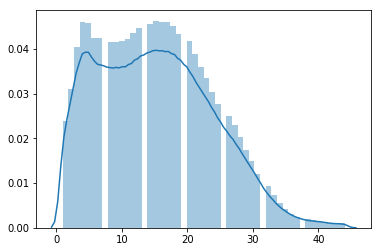

In [71]:
import seaborn as sns

x = poss.PossTime.values
x = np.array(list(x))
print(x.shape)

sns.distplot(x)

In [90]:
print(poss.EventTypeBegin.unique())

['made2_jump' 'turnover' 'reb_def' 'reb_off' 'made3_jump' 'made2_dunk'
 'made1_free' 'made2_lay' 'made2_tip' 'reb_team']


normal 0.8202174905574233


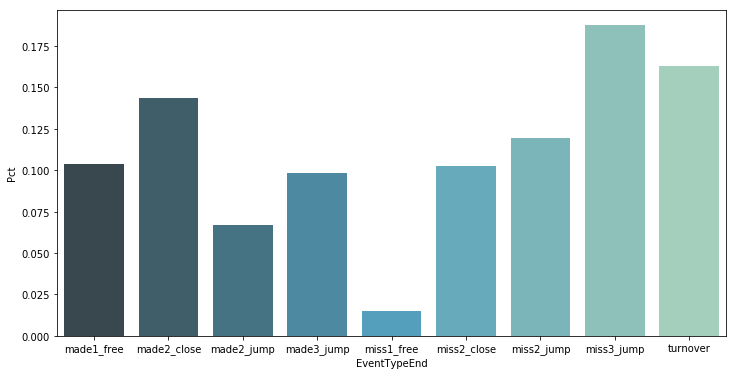

In [104]:

# speed = [0.1, 17.5, 40, 48, 52, 69, 88]
# lifespan = [2, 8, 70, 1.5, 25, 12, 28]
# index = ['snail', 'pig', 'elephant', 'rabbit', 'giraffe', 'coyote', 'horse']
# df = pd.DataFrame({'speed': speed, 'lifespan': lifespan}, index=index)
# fig, ax = plt.

gb = poss.groupby(['EventTypeEnd'])['PossTime'].count()

gb = gb/gb.sum()

expected_value = gb.loc['made1_free'] + 2*gb.loc['made2_close'] + 2*gb.loc['made2_jump'] + 3*gb.loc['made3_jump']

print("normal",expected_value)

gb = gb.reset_index()

gb = gb.rename(columns={'PossTime':'Pct'})


fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.barplot(gb.EventTypeEnd, gb.Pct, palette="GnBu_d")



oreb 0.8918340052721352


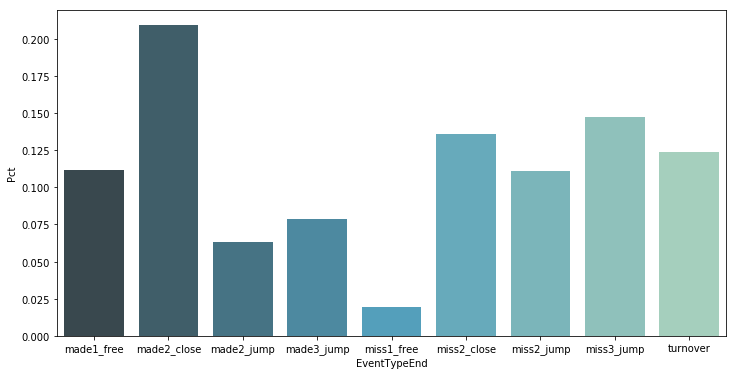

In [105]:
orebs = poss.loc[poss['EventTypeBegin']=='reb_off']

gb = orebs.groupby(['EventTypeEnd'])['PossTime'].count()

gb = gb/gb.sum()

expected_value = gb.loc['made1_free'] + 2*gb.loc['made2_close'] + 2*gb.loc['made2_jump'] + 3*gb.loc['made3_jump']

print("oreb",expected_value)

gb = gb.reset_index()

gb = gb.rename(columns={'PossTime':'Pct'})


fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.barplot(gb.EventTypeEnd, gb.Pct, palette="GnBu_d")

dreb 0.8145992572979635


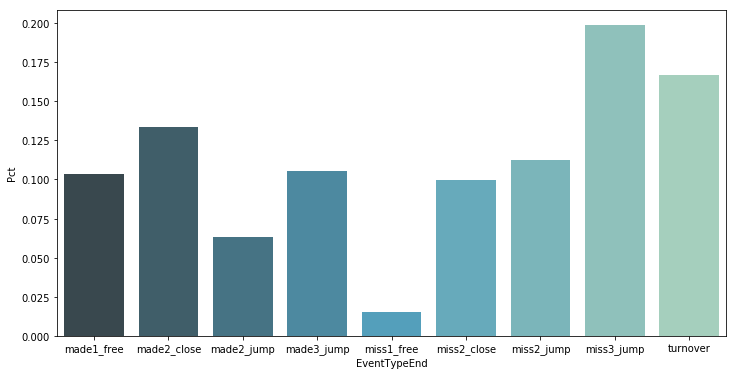

In [106]:
drebs = poss.loc[poss['EventTypeBegin']=='reb_def']

gb = drebs.groupby(['EventTypeEnd'])['PossTime'].count()

gb = gb/gb.sum()

expected_value = gb.loc['made1_free'] + 2*gb.loc['made2_close'] + 2*gb.loc['made2_jump'] + 3*gb.loc['made3_jump']

print("dreb",expected_value)

gb = gb.reset_index()

gb = gb.rename(columns={'PossTime':'Pct'})

fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.barplot(gb.EventTypeEnd, gb.Pct, palette="GnBu_d")

turnover 0.8632717748776023


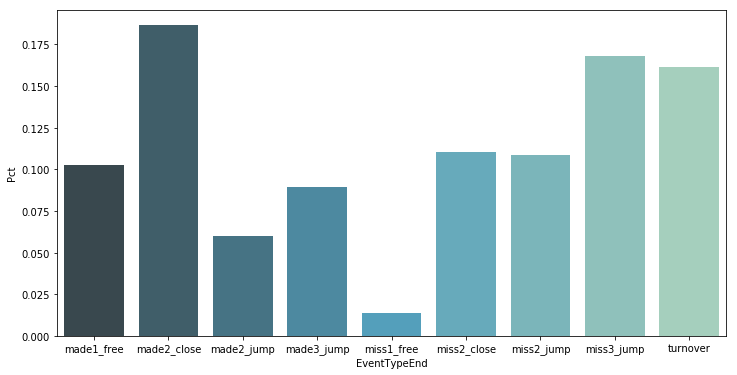

In [107]:
tos = poss.loc[poss['EventTypeBegin']=='turnover']

gb = tos.groupby(['EventTypeEnd'])['PossTime'].count()

gb = gb/gb.sum()

expected_value = gb.loc['made1_free'] + 2*gb.loc['made2_close'] + 2*gb.loc['made2_jump'] + 3*gb.loc['made3_jump']

print("turnover",expected_value)

gb = gb.reset_index()

gb = gb.rename(columns={'PossTime':'Pct'})

fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.barplot(gb.EventTypeEnd, gb.Pct, palette="GnBu_d")

pos 0.7853681884254937


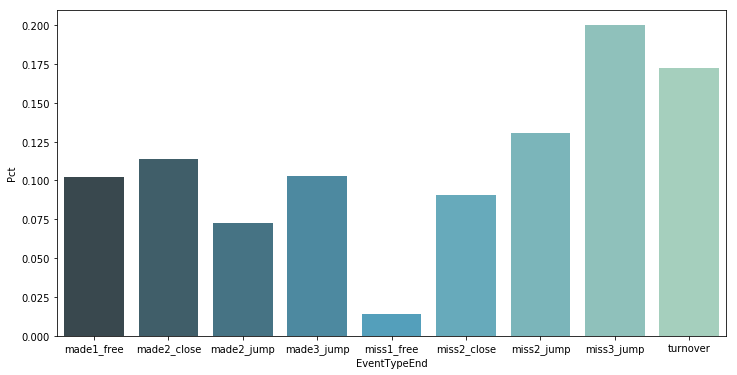

In [109]:
ms = poss.loc[poss['EventTypeBegin']=='made_shot']

gb = ms.groupby(['EventTypeEnd'])['PossTime'].count()

gb = gb/gb.sum()

expected_value = gb.loc['made1_free'] + 2*gb.loc['made2_close'] + 2*gb.loc['made2_jump'] + 3*gb.loc['made3_jump']

print("pos",expected_value)

gb = gb.reset_index()

gb = gb.rename(columns={'PossTime':'Pct'})

fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.barplot(gb.EventTypeEnd, gb.Pct, palette="GnBu_d")

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing



ValueError: color kwarg must have one color per data set. 819162 data sets and 1 colors were provided

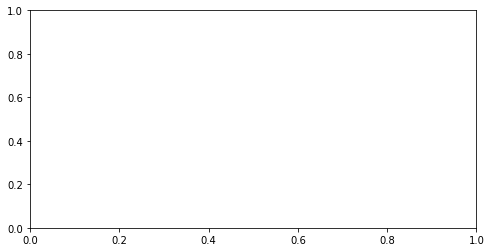